In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import  matplotlib.pyplot   as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from torchsummary import summary

torch.manual_seed(101)
torch.cuda.manual_seed(101)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device") 

Using cpu device


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img1_dir, img2_dir, img3_dir, coords_file, transform=None):
        # Directorios de imágenes y archivo CSV de coordenadas
        self.img1_dir = img1_dir
        self.img2_dir = img2_dir
        self.img3_dir = img3_dir
        self.coords = np.load(coords_file)[:, 1:]
        # self.coords = self.coords.reshape(self.coords.shape[0],int(self.coords.shape[1]/3),3)
        # for i in range(self.coords.shape[0]):
        #     # Ordenar por las columnas 2 (z), 1 (y) y 0 (x)
        #     self.coords[i] = self.coords[i][np.lexsort((self.coords[i][:, 2], self.coords[i][:, 1], self.coords[i][:, 0]))]
        # self.coords = self.coords.reshape(self.coords.shape[0],self.coords.shape[1]*self.coords.shape[2])
        self.transform = transform

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):

        # Cargar las tres imágenes
        img1_path = os.path.join(self.img1_dir, f"isar_{idx+1}_1.png")
        img2_path = os.path.join(self.img2_dir, f"isar_{idx+1}_2.png")
        img3_path = os.path.join(self.img3_dir, f"isar_{idx+1}_3.png")
        img1 = Image.open(img1_path).convert("L")
        img2 = Image.open(img2_path).convert("L")
        img3 = Image.open(img3_path).convert("L")

        # Aplicar transformaciones si las hay
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        # Obtener el vector de coordenadas de salida
        coords = torch.tensor(self.coords[idx,:], dtype=torch.float32)

        return img1.to(device), img2.to(device), img3.to(device), coords.to(device)

class CNNModule(nn.Module):
    def __init__(self):
        super(CNNModule, self).__init__()
        # Capas convolucionales
        self.conv1 = nn.LazyConv2d(96, kernel_size=22, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.LazyConv2d(256, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv4 = nn.LazyConv2d(384, kernel_size=3, padding=1)
        self.conv5 = nn.LazyConv2d(256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.ReLU = nn.ReLU()
        self.Flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.conv4(x)
        x = self.ReLU(x)
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.pool3(x)
        x = self.Flatten(x)
        return x
    
class CoordinatePredictor(nn.Module):
    def __init__(self,coords_width):
        super(CoordinatePredictor, self).__init__()
        # CNN compartida para las tres imágenes
        self.cnn = CNNModule()

        # Fully connected layers
        self.fc1 = nn.LazyLinear(4096)  # Ajustar el tamaño si las imágenes son diferentes
        self.fc2 = nn.LazyLinear(4096)
        #self.Dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.LazyLinear(coords_width)  # 3*N salidas, una por coordenada (x, y, z) de cada uno de los N vertices

    def forward(self, image1, image2, image3):
        # Procesar cada imagen a través de la CNN
        image1_features = self.cnn(image1)
        image2_features = self.cnn(image2)
        image3_features = self.cnn(image3)

        # Concatenar las características de las tres imágenes
        concat_images = torch.cat((image1_features, image2_features, image3_features), dim=1)

        # Pasar por las capas densas
        x = F.relu(self.fc1(concat_images))
        #x = self.Dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.Dropout(x)
        output_coords = self.fc3(x)

        return output_coords

In [ ]:
# Definir las transformaciones (por ejemplo, redimensionar las imágenes y normalizarlas)
transform = transforms.Compose([
    transforms.Resize((128, 128)),                                        # Cambia esto según el tamaño de tus imágenes
    transforms.ToTensor(),                                              # Convertir las imágenes a tensores
    transforms.Normalize(mean=[0.5], std=[0.5])     # Normalización
])

# Crear el dataset personalizado
dataset = CustomDataset(
    img1_dir="C:\\Users\\Diego\\Desktop\\N101\\Datasets\\Regression\\Cube\\Img\\ISAR", 
    img2_dir="C:\\Users\\Diego\\Desktop\\N101\\Datasets\\Regression\\Cube\\Img\\ISAR", 
    img3_dir="C:\\Users\\Diego\\Desktop\\N101\\Datasets\\Regression\\Cube\\Img\\ISAR",
    coords_file="C:\\Users\\Diego\\Desktop\\N101\\Datasets\\Regression\\Cube\\Img\\coords.npy",
    transform=transform
)

# Dividir el dataset en entrenamiento y validación
train_size = int(0.7 * len(dataset))  # 70% para entrenamiento
val_size = int(0.15 * len(dataset))  # 15% para validación
test_size = len(dataset) - train_size - val_size  # 15% para test

generator = torch.Generator().manual_seed(101)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# Crear DataLoaders para iterar sobre los datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Inicializar modelo
model = CoordinatePredictor(dataset.coords.shape[1])
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          46,560
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Flatten-14                 [-

In [8]:
# Cargar un modelo
model.load_state_dict(torch.load('C:\\Users\\Diego\\Desktop\\N101\\CNN\\Modelos\\Cube_ISAR_1000samples_100ep_32bs_noroot.pth',map_location=torch.device('cpu')))
model.eval()

C:\Users\Diego\AppData\Local\Temp\ipykernel_12180\2680781036.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:\\Users\\Diego\\Desktop\

CoordinatePredictor(
  (cnn): CNNModule(
    (conv1): Conv2d(1, 96, kernel_size=(22, 22), stride=(2, 2), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ReLU): ReLU()
    (Flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=27648, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=24, bias=True)
)

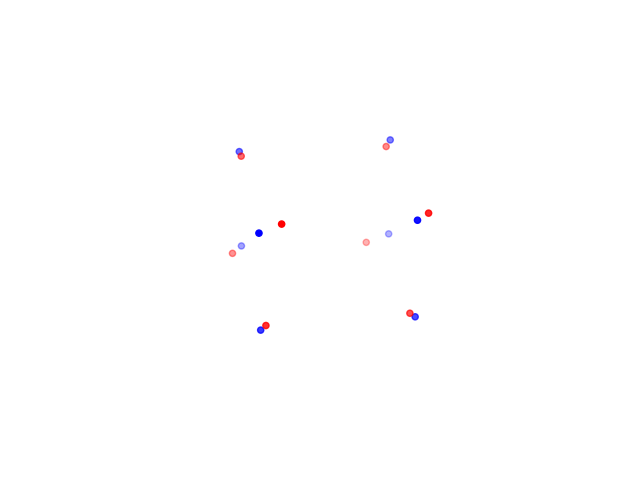

In [14]:
%matplotlib widget
# Importante incluir esta linea al comienzo de la celda donde se quiere visualizar el resultado

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
random_ch = np.random.randint(0, len(test_loader))

with torch.no_grad():
    for i, (img1, img2, img3, target_coords) in enumerate(test_loader):
        if i == random_ch:
            sample_im1 = img1[0,0,:].reshape(1,1,img1.shape[2],img1.shape[3]).to(device)
            sample_im2 = img2[0,0,:].reshape(1,1,img2.shape[2],img2.shape[3]).to(device)
            sample_im3 = img3[0,0,:].reshape(1,1,img3.shape[2],img3.shape[3]).to(device)
            sample_target = target_coords[0,:].reshape(1,-1)
            break

def plot_sample(output, target):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    ax.axes.set_xlim3d(left=-2, right=2) 
    ax.axes.set_ylim3d(bottom=-2, top=2)
    ax.axes.set_zlim3d(bottom=-2, top=2) 
    fig.add_axes(ax)
    ax.set_axis_off()

    ax.scatter(output[:,0], output[:,1], output[:,2], c='red')
    ax.scatter(target[:,0], target[:,1], target[:,2], c='blue')

    plt.show()

output = model(sample_im1, sample_im2, sample_im3)[0].reshape((-1,3)).detach().cpu().numpy()
target = sample_target.reshape((-1,3)).detach().cpu().numpy()
plot_sample(output,target)

In [49]:
print(random_ch)
print(torch.seed())

5
2175557628041400
